<a href="https://colab.research.google.com/github/tejasaz/NitroEnclaves/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform a looping with a quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align}
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
import numpy as np
import matplotlib
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)

NumPy: 2.0.2
Matplotlib: 3.10.0


In [2]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.45
Length  = 0.14
Inertia = 0.09
Dt      = 0.04
state size   = 6
control size = 2


In [3]:
import numpy as np
import quadrotor

def discretize_dynamics(x, u, dt=quadrotor.DT):
    """
    Forward Euler discretization of the quadrotor dynamics.
    x = [px, vx, py, vy, theta, omega]
    u = [u1, u2]
    """
    px, vx, py, vy, th, om = x
    u1, u2 = u

    m = quadrotor.MASS
    I = quadrotor.INERTIA
    r = quadrotor.LENGTH
    g = quadrotor.GRAVITY

    # continuous dynamics
    dpx = vx
    dvx = -(u1 + u2) * np.sin(th) / m
    dpy = vy
    dvy = (u1 + u2) * np.cos(th) / m - g
    dth = om
    dom = r * (u1 - u2) / I

    # euler step
    x_next = np.array([
        px + dt * dpx,
        vx + dt * dvx,
        py + dt * dpy,
        vy + dt * dvy,
        th + dt * dth,
        om + dt * dom
    ])

    return x_next


In [4]:
import numpy as np

def running_cost(x, u, k, N):
    px, vx, py, vy, th, om = x
    u1, u2 = u
    th_target = 2.0 * np.pi * (k / N)

    w_pos = 5.0
    w_vel = 0.5
    w_ang = 4.0
    w_u   = 0.001

    return (
        w_pos * (px**2 + py**2)
        + w_vel * (vx**2 + vy**2)
        + w_ang * (th - th_target)**2
        + w_u * (u1**2 + u2**2)
    )





def terminal_cost(x):
    px, vx, py, vy, th, om = x
    w_ang_final = 40.0         # tighten final angle
    w_pos_final = 500.0        # strong force to return to origin
    return w_ang_final * (th - 2*np.pi)**2 + w_pos_final * (px**2 + py**2)






def control_constraints(u):
    """
    Enforce 0 <= u_i <= 10.
    Returns inequality constraint values c(u) <= 0.
    """
    u1, u2 = u
    c = np.array([
        -u1,        # u1 >= 0  ->  -u1 <= 0
        u1 - 10,    # u1 <= 10 ->   u1 - 10 <= 0
        -u2,
        u2 - 10
    ])
    return c


In [5]:
import numpy as np
import quadrotor

n_x = quadrotor.DIM_STATE
n_u = quadrotor.DIM_CONTROL
DT = quadrotor.DT

def running_cost_derivs(x, u, k, N, w_pos=0.1, w_ang=5.0, w_u=0.001):
    px, vx, py, vy, th, om = x
    u1, u2 = u

    th_target = 2.0 * np.pi * (k / float(N))

    grad_x = np.zeros(n_x)
    grad_x[0] = 2.0 * w_pos * px
    grad_x[2] = 2.0 * w_pos * py
    grad_x[4] = 2.0 * w_ang * (th - th_target)

    grad_u = np.zeros(n_u)
    grad_u[0] = 2.0 * w_u * u1
    grad_u[1] = 2.0 * w_u * u2

    Hess_xx = np.zeros((n_x, n_x))
    Hess_xx[0, 0] = 2.0 * w_pos
    Hess_xx[2, 2] = 2.0 * w_pos
    Hess_xx[4, 4] = 2.0 * w_ang

    Hess_uu = np.zeros((n_u, n_u))
    Hess_uu[0, 0] = 2.0 * w_u
    Hess_uu[1, 1] = 2.0 * w_u

    Hess_xu = np.zeros((n_x, n_u))

    return grad_x, grad_u, Hess_xx, Hess_uu, Hess_xu

def terminal_cost_derivs(x, w_terminal_theta=10.0):
    px, vx, py, vy, th, om = x
    grad_x = np.zeros(n_x)
    grad_x[4] = 2.0 * w_terminal_theta * (th - 2.0 * np.pi)
    Hess_xx = np.zeros((n_x, n_x))
    Hess_xx[4, 4] = 2.0 * w_terminal_theta
    return grad_x, Hess_xx

def traj_cost_grad_hess(x_traj, u_traj, N):
    total_dim = (N + 1) * n_x + N * n_u
    grad = np.zeros(total_dim)
    Hess = np.zeros((total_dim, total_dim))

    def idx_x(k):
        return k * (n_x + n_u)
    def idx_u(k):
        return k * (n_x + n_u) + n_x

    for k in range(N):
        xk = x_traj[k]
        uk = u_traj[k]
        gx, gu, Hxx, Huu, Hxu = running_cost_derivs(xk, uk, k, N)

        ix = idx_x(k)
        iu = idx_u(k)

        grad[ix:ix + n_x] += gx
        grad[iu:iu + n_u] += gu

        Hess[ix:ix + n_x, ix:ix + n_x] += Hxx
        Hess[iu:iu + n_u, iu:iu + n_u] += Huu
        Hess[ix:ix + n_x, iu:iu + n_u] += Hxu
        Hess[iu:iu + n_u, ix:ix + n_x] += Hxu.T

    xN = x_traj[N]
    gN, HN = terminal_cost_derivs(xN)
    ixN = idx_x(N)
    grad[ixN:ixN + n_x] += gN
    Hess[ixN:ixN + n_x, ixN:ixN + n_x] += HN

    return grad, Hess

def cont_dynamics_and_jacobians(x, u):
    px, vx, py, vy, th, om = x
    u1, u2 = u
    m = quadrotor.MASS
    I = quadrotor.INERTIA
    r = quadrotor.LENGTH
    g = quadrotor.GRAVITY_CONSTANT

    dpx = vx
    dvx = -(u1 + u2) * np.sin(th) / m
    dpy = vy
    dvy = (u1 + u2) * np.cos(th) / m - g
    dth = om
    dom = r * (u1 - u2) / I

    f_cont = np.array([dpx, dvx, dpy, dvy, dth, dom])

    A = np.zeros((n_x, n_x))
    B = np.zeros((n_x, n_u))

    A[0, 1] = 1.0
    A[1, 4] = -(u1 + u2) * np.cos(th) / m
    A[2, 3] = 1.0
    A[3, 4] = -(u1 + u2) * np.sin(th) / m
    A[4, 5] = 1.0

    B[1, 0] = -np.sin(th) / m
    B[1, 1] = -np.sin(th) / m
    B[3, 0] = np.cos(th) / m
    B[3, 1] = np.cos(th) / m
    B[5, 0] = r / I
    B[5, 1] = -r / I

    return f_cont, A, B

def linearize_dynamics_constraints(x_traj, u_traj, N):
    total_vars = (N + 1) * n_x + N * n_u
    n_eq = n_x * N
    G = np.zeros((n_eq, total_vars))
    g = np.zeros(n_eq)

    def idx_x(k):
        return k * (n_x + n_u)
    def idx_u(k):
        return k * (n_x + n_u) + n_x

    row = 0
    for k in range(N):
        xk = x_traj[k]
        uk = u_traj[k]
        xkp1 = x_traj[k + 1]

        f_cont, A_cont, B_cont = cont_dynamics_and_jacobians(xk, uk)
        f_discrete = xk + DT * f_cont
        A = np.eye(n_x) + DT * A_cont
        B = DT * B_cont

        rhs = f_discrete - xkp1

        ix_k = idx_x(k)
        iu_k = idx_u(k)
        ix_kp1 = idx_x(k + 1)

        G[row:row + n_x, ix_kp1:ix_kp1 + n_x] += np.eye(n_x)
        G[row:row + n_x, ix_k:ix_k + n_x] += -A
        G[row:row + n_x, iu_k:iu_k + n_u] += -B

        g[row:row + n_x] = rhs

        row += n_x

    return G, g

def linearize_control_inequalities(u_traj, N):
    total_vars = (N + 1) * n_x + N * n_u
    n_ineq = 4 * N
    G_ineq = np.zeros((n_ineq, total_vars))
    g_ineq = np.zeros(n_ineq)

    def idx_u(k):
        return k * (n_x + n_u) + n_x

    row = 0
    for k in range(N):
        u1, u2 = u_traj[k]
        iu = idx_u(k)

        G_ineq[row, iu + 0] = -1.0
        g_ineq[row] = -(-u1)

        G_ineq[row + 1, iu + 0] = 1.0
        g_ineq[row + 1] = -(u1 - 10.0)

        G_ineq[row + 2, iu + 1] = -1.0
        g_ineq[row + 2] = -(-u2)

        G_ineq[row + 3, iu + 1] = 1.0
        g_ineq[row + 3] = -(u2 - 10.0)

        row += 4

    return G_ineq, g_ineq

def constraint_violation(x_traj, u_traj, N):
    eq_sum = 0.0
    for k in range(N):
        xk = x_traj[k]
        uk = u_traj[k]
        xkp1 = x_traj[k + 1]

        f_cont, _, _ = cont_dynamics_and_jacobians(xk, uk)
        f_discrete = xk + DT * f_cont
        res = xkp1 - f_discrete
        eq_sum += np.sum(np.abs(res))

    ineq_sum = 0.0
    for k in range(N):
        u1, u2 = u_traj[k]
        c = np.array([-u1, u1 - 10.0, -u2, u2 - 10.0])
        ineq_sum += np.sum(np.maximum(0.0, c))

    total = eq_sum + ineq_sum
    return total, eq_sum, ineq_sum

def state_position_constraints(x_traj):
    px_min, px_max = -1.0, 1.0
    py_min, py_max = -0.5, 1.5

    cons = []
    for x in x_traj:
        px, vx, py, vy, th, om = x
        cons.append(px - px_max)
        cons.append(px_min - px)
        cons.append(py - py_max)
        cons.append(py_min - py)
    return np.array(cons)


In [6]:
import matplotlib.animation as animation
import matplotlib as mp
mp.animation = animation


Final cost: 2101.140486952631
Violation: 5.484124324480401e-13 eq: 6.535377453081529e-14 ineq: 4.830586579172248e-13 pos_viol: 4.440892098500626e-16


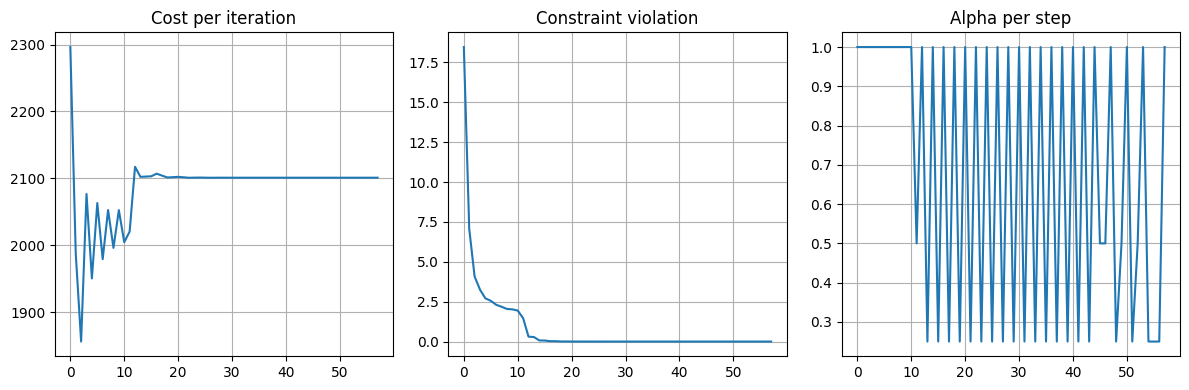

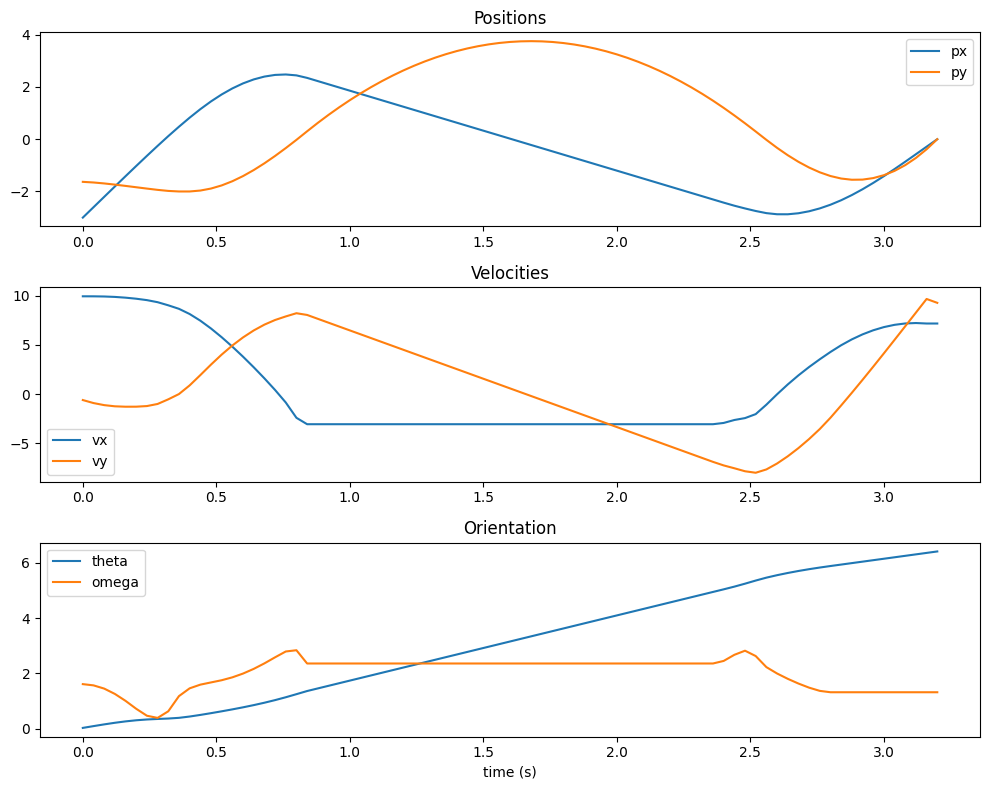

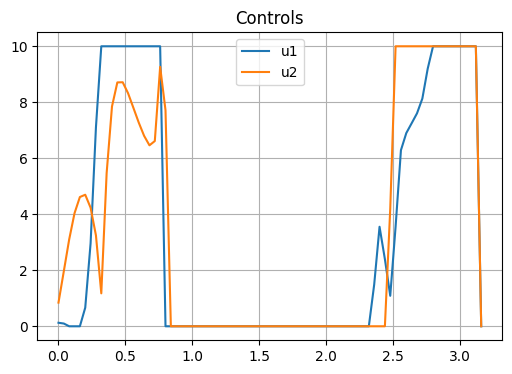

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAaP9tZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAR
IWWIhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAAAwAANJjQfjN3asOGIAAAAwAm
AAYIA2ADMAR3AEmGJ+s/AAvBEWQEnA/MlSYUZPaodejibpEKK0iWFFh63emKh7s+0cyc7gmSe0m6
NdUr2am+mi/UOrkKsunbr4T+qLLZcnUNdsVAUh4Pp2Ph39hyDgyVGNKPkX+M7h2d5lspyEGTERHX
53Boux6hBNQ4gd74CMx3/TWPeWQe6fK6YcYBMXlB+4Yw0SGYCKJQBg4h4fEWIiCDbLH+xESwmUOQ
eCCfPyJuMMfLqyh3Xl6NMPuczedIqffnrHs1T6suOLL5MZXvOUpkE+K8whq8T75r0DSWqwlh2CvJ
KMowdP8FecMCCYNd87riOmLIY8UCq2QVYnlMRCV5nUnkCkiIBuuamJ8N6VPyf8f+fH+Wx6XLUbLa
4GpsB3Ev0o9VGIFbl/NrQIJFYaI8+TVNRHedJampFH59o7JHt3hdTvtZESV+cTFtXm3MWiO6d6Na
Nes2JxyIga8j/MW3CqBIXjhkLWvdScKZvg8MVaqrvYXuPHtXdox+2jtMl6rE9m/6s+6Cy5TIeNja
XXyIeyZ+XqGibRzO+clKUU8YWj4rZIaUkBqvdT8HuUUf+o5XJ27APUQkCUnocn6j49qq8oSXPQeJ
OrVByQ/ASTnd97DNT2BXDqBcJctYnTo6HVgovwxSWB9G+GBH5N37v/voXSu8KEpezsoE9quqBDO9
PecYPscN7W5KLQ/HhZr/5fknJz8utYg1wnwFmIw3MlHmP3OL0k0UfeSfFbEER8u+UGJaG59ZY7mw
xh87IhL+NAZX5zOxKS07Ze4mEa3OYT6LEXcvTm7Aon7WhYaBnzUHarsABI6NlKWq8BFfhUtK4Kqy
i0Gg5zcEzvR4BLpXFvTvFw8c2HcZlaNPXcoVMPkLChZY3aWsr9+1LH//pMjj4NAQeyNbBBj5DfTb
51VPzzNObc0Sm2CEqRF0mj9mFS0iuMJkmpkY6Wba30Q7StAXsW4J8f+XP79TBa+XA2WTIBl2488N
5/ltt3RlVPaWm8jjAuPnoUsf+kIS1/UqmjBfD68Dd9hguqdP1EIbAeN92rM2maEY4veEDTlTGdd4
KKxXy500biiKApJ0nNi+b9cXRVKaUt6uxdehzyka2DPuP/kujVIRfOOwDkVW0aL/zrp8XsW/Laz7
bpni2wXGGV/OXartU3t8byrOJRdcakIcEMtpwCzMBAsfB4IIb8G1gve5Lk2/++EdgoBvipBP6AXh
/+URURZtpxYzBlIq4Q8PxRvomAPQ3kYKsAAG8h8vo2uGOgkvSVBiy2mdmh6K7pSYG9b1SlrFwjam
AH3GzvUAAAMAAAMAAAMAAAMBYxr8V7iXsYDIObqVl0I/0UF3f+b7cj4zp0/Cb4t/vk2U2WYiH5Bf
8XNgn7H1HzV3k/lGCZGYdM12Wdq3z2+mR53DtIzKW4G8PHZwJUsCNzAZNnqOrK/5GkQjnQqHwPaQ
PCwtoOLfwynrPjbv+fPa42EEXyaVaU6pt5IEYlmI+Okg9q8wSIuJK9A1iYbaqGtM3acAZokGEHxg
ndp39TxO777lYg4YTF4C/xbcVVv17IC6+dVsVz5d76tYr5YwOAX7hAP+NfTC1w3ote7xHzSe9EcZ
w3hl7tWjz27WRZ6NqsEYKVv1crvBM4aZuOH3xuc7q8mD3RN0QTsaSCUOxbM/7YJli6hqVxKgfGSS
7yy6Dd2HYyewHcbdLechHPi8ggBMBAVN6nxPzmdeqli9/yo3scSAXUrFpAaBnmZm5N/W8Ny62qoP
Toqvzpzu641M/MbcCI/iTAAAAwAAAwAAAwADSGwj9in2KgkSyH3WaxAu7C2WWJ7m0Eq3ccJPIFCQ
X/GIA/5fid8c+fnlqk7InLkyWFg1hjI4qTqp97Bg7zjvjwGbQH8MC/HI54EFgLAx74Ql4lQEtA0f
KpqElNzPOIlNI1NTTBTSBnbjt2G/ZHqljM2Z92k5csJ4gdsO6KH8eASeeUdM0ltkaud6Cd3f22SB
47xn6wb3MfF2q5IZ6jPpU7lm9+M9ukqYjY/4X7gg2rtkQ/yMOT+ABYRB7484gNrAV+fhxIjEuSVV
7/nTW7b4A9dhLCg+iWNQGfor8lFKME6hDDdxEHtnTMsv1PrOpgid3+9ho7j2Ar38f1cZ1Zi3x1de
ntJ0c3efW6AntvKK1XDv6+gB7er8zYD5T+wJosPelN0j3fpDg/GSVPA5Sa61EDlbF9wyqTW8kqRT
+xch+ZcoAAAEjp6IzB/h2CQAAAMAAAMABOpCq7OwWMdvHCgevEb4QeVQ5QnU/sz+/Y5Mn4QhnfMH
FjFsVZX0UK+pmh7uTL74evwZ6dqhJgqzgm6gyb2i3Wb7xYN4cbTiA9+J/MQTjQPR+X8IDtcNwtt+
+QXupcaWZNiNxwfzQNXDRpOgSkcMAdomJlKyAhZe6lHp1Qb3wctCsbRxbQfAKfnyeUcoWne++Xgm
GdYh8Lwui/hmJpr6PCf2qw5JN/WCSl7bRsp/wxzXMolTk/DhBePWBQA4gfuiYDMrrbCaMkKOnEb8
NFUdBTWkKdTlAGyQSXT+Bzh2xzEk0Lls279B0EfLtiNo5L9rRd9C5zD3zev2TWMu+AyuCoATD2sN
jk3zPXNT5Ujm81R1yIkln2n46BAKthhOChWvXrwPyTxWgFycrY3K3bup/SQPViP7kHxEFO/lc+hP
d37/JOZwEsbu8q00fBAJCfXDjw4cm+DlrZrW44bxhTDJRf8d77J73/r/am4apS1GAt4JvKGoXkv4
bk+v/fHxA22yPXCHUIYHaJwWh9DtATDmhl6QrDlxRAaCNPo929AyCzKsjECs02jMH6NU9h5+tN+O
bwchGMeCdhJUGLyuR2lvq

In [7]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import quadrotor

N = 80
max_iters = 200
rho = 0.5
tol_step = 1e-6
tol_violation = 1e-7

n_x = quadrotor.DIM_STATE
n_u = quadrotor.DIM_CONTROL
DT = quadrotor.DT
total_dim = (N + 1) * n_x + N * n_u

def idx_x(k): return k * (n_x + n_u)
def idx_u(k): return k * (n_x + n_u) + n_x

m = quadrotor.MASS
g = quadrotor.GRAVITY_CONSTANT
u_hover = (m * g / 2.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

def running_cost(x, u, k, N):
    px, vx, py, vy, th, om = x
    u1, u2 = u
    th_target = 2.0 * np.pi * (k / N)
    w_pos = 2.0
    w_vel = 0.2
    w_ang = 4.0
    w_u = 0.001
    cost = 0.0
    cost += w_pos * (px**2 + py**2)
    cost += w_vel * (vx**2 + vy**2)
    cost += w_ang * (th - th_target)**2
    cost += w_u * (u1**2 + u2**2)
    return cost

def terminal_cost(x):
    px, vx, py, vy, th, om = x
    w_ang_final = 20.0
    w_pos_final = 10.0
    return w_ang_final * (th - 2*np.pi)**2 + w_pos_final * (px**2 + py**2)

def state_position_constraints(x_traj):
    px_min, px_max = -3.0, 3.0
    py_min, py_max = -2.0, 4.0
    cons = []
    for x in x_traj:
        px, vx, py, vy, th, om = x
        cons.append(px - px_max)
        cons.append(px_min - px)
        cons.append(py - py_max)
        cons.append(py_min - py)
    return np.array(cons)

x_traj = np.zeros((N + 1, n_x))
u_traj = np.zeros((N, n_u))
for k in range(N + 1):
    t = k / N
    px = 0.5 * np.sin(np.pi * t)
    py = 0.5 + 0.5 * t
    vx = 0.5 * np.pi * np.cos(np.pi * t)
    vy = 0.5
    th = 2.0 * np.pi * t
    om = 1.0
    x_traj[k] = np.array([px, vx, py, vy, th, om])
for k in range(N):
    base = m * g / 2.0
    spin = 0.15 * base * (1 - k/N)
    u_traj[k] = np.array([base + spin, base - spin])

def pack_traj(x_traj, u_traj):
    z = np.zeros(total_dim)
    for k in range(N):
        z[idx_x(k):idx_x(k) + n_x] = x_traj[k]
        z[idx_u(k):idx_u(k) + n_u] = u_traj[k]
    z[idx_x(N):idx_x(N) + n_x] = x_traj[N]
    return z

def unpack_traj(z):
    x_traj = np.zeros((N + 1, n_x))
    u_traj = np.zeros((N, n_u))
    for k in range(N):
        x_traj[k] = z[idx_x(k):idx_x(k) + n_x]
        u_traj[k] = z[idx_u(k):idx_u(k) + n_u]
    x_traj[N] = z[idx_x(N):idx_x(N) + n_x]
    return x_traj, u_traj

def full_traj_cost(x_traj, u_traj, N):
    cost = 0.0
    for k in range(N):
        cost += running_cost(x_traj[k], u_traj[k], k, N)
    cost += terminal_cost(x_traj[N])
    return cost

cost_log = []
violation_log = []
alpha_log = []
step_norm_log = []
f_best = np.inf
c_best = np.inf

z = pack_traj(x_traj, u_traj)

for it in range(max_iters):
    x_traj, u_traj = unpack_traj(z)
    grad, Hess = traj_cost_grad_hess(x_traj, u_traj, N)
    G_eq, g_eq = linearize_dynamics_constraints(x_traj, u_traj, N)

    ixN = idx_x(N)
    G_final = np.zeros((2, total_dim))
    G_final[0, ixN + 0] = 1.0
    G_final[1, ixN + 2] = 1.0
    g_final = -np.array([x_traj[N, 0], x_traj[N, 2]])

    G_eq = np.vstack([G_eq, G_final])
    g_eq = np.hstack([g_eq, g_final])
    G_ineq, g_ineq = linearize_control_inequalities(u_traj, N)

    pos_cons = state_position_constraints(x_traj)
    n_pos = len(pos_cons)
    G_pos = np.zeros((n_pos, total_dim))
    g_pos = -pos_cons
    row = 0
    for k in range(N+1):
        ix = idx_x(k)
        G_pos[row, ix + 0] = 1.0; row += 1
        G_pos[row, ix + 0] = -1.0; row += 1
        G_pos[row, ix + 2] = 1.0; row += 1
        G_pos[row, ix + 2] = -1.0; row += 1
    if G_ineq.size == 0:
        G_ineq = G_pos
        g_ineq = g_pos
    else:
        G_ineq = np.vstack([G_ineq, G_pos])
        g_ineq = np.hstack([g_ineq, g_pos])

    reg = 1e-8
    H_qp = Hess + reg * np.eye(total_dim)
    H_qp += 1e-6 * np.eye(total_dim)
    q_qp = grad.copy()

    Dz = cp.Variable(total_dim)
    objective = 0.5 * cp.quad_form(Dz, H_qp) + q_qp @ Dz

    constraints = []
    if G_eq.shape[0] > 0:
        constraints.append(G_eq @ Dz == g_eq)
    if G_ineq.shape[0] > 0:
        constraints.append(G_ineq @ Dz <= g_ineq)

    prob = cp.Problem(cp.Minimize(objective), constraints)
    try:
        prob.solve(solver=cp.OSQP, verbose=False, eps_abs=1e-6, eps_rel=1e-6, max_iter=200000)
    except Exception as e:
        try:
            prob.solve(solver=cp.OSQP, verbose=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=200000)
        except Exception as e2:
            break

    if Dz.value is None:
        break

    delta_z = Dz.value
    step_norm = np.linalg.norm(delta_z)
    step_norm_log.append(step_norm)

    alpha = 1.0
    accepted = False
    max_trial = 25
    curr_cost = full_traj_cost(x_traj, u_traj, N)
    curr_viol, _, _ = constraint_violation(x_traj, u_traj, N)
    curr_viol += np.sum(np.maximum(0.0, state_position_constraints(x_traj)))

    for _ in range(max_trial):
        z_trial = z + alpha * delta_z
        x_trial, u_trial = unpack_traj(z_trial)
        try:
            cost_trial = full_traj_cost(x_trial, u_trial, N)
            viol_trial, _, _ = constraint_violation(x_trial, u_trial, N)
            viol_trial += np.sum(np.maximum(0.0, state_position_constraints(x_trial)))
        except Exception:
            alpha *= rho
            continue

        if cost_trial < f_best or viol_trial < c_best:
            accepted = True
            if cost_trial < f_best:
                f_best = cost_trial
            if viol_trial < c_best:
                c_best = viol_trial
            z = z_trial
            alpha_log.append(alpha)
            cost_log.append(cost_trial)
            violation_log.append(viol_trial)
            break
        alpha *= rho

    if not accepted:
        break

    if step_norm < tol_step and violation_log[-1] < tol_violation:
        break

x_final, u_final = unpack_traj(z)

total_viol, eq_sum, ineq_sum = constraint_violation(x_final, u_final, N)
pos_viol_final = np.sum(np.maximum(0.0, state_position_constraints(x_final)))

if eq_sum > 1e-3:
    x_proj = np.zeros_like(x_final)
    x_proj[0] = x0.copy()
    for k in range(N):
        f_cont, _, _ = cont_dynamics_and_jacobians(x_proj[k], u_final[k])
        x_proj[k+1] = x_proj[k] + DT * f_cont
    x_final = x_proj.copy()
    total_viol, eq_sum, ineq_sum = constraint_violation(x_final, u_final, N)
    pos_viol_final = np.sum(np.maximum(0.0, state_position_constraints(x_final)))

print("Final cost:", full_traj_cost(x_final, u_final, N))
print("Violation:", total_viol, "eq:", eq_sum, "ineq:", ineq_sum, "pos_viol:", pos_viol_final)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.plot(cost_log); plt.title("Cost per iteration"); plt.grid()
plt.subplot(1, 3, 2); plt.plot(violation_log); plt.title("Constraint violation"); plt.grid()
plt.subplot(1, 3, 3); plt.plot(alpha_log); plt.title("Alpha per step"); plt.grid()
plt.tight_layout(); plt.show()

time = np.arange(N + 1) * DT
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(time, x_final[:, 0], label='px')
plt.plot(time, x_final[:, 2], label='py')
plt.legend(); plt.title("Positions")

plt.subplot(3, 1, 2)
plt.plot(time, x_final[:, 1], label='vx')
plt.plot(time, x_final[:, 3], label='vy')
plt.legend(); plt.title("Velocities")

plt.subplot(3, 1, 3)
plt.plot(time, x_final[:, 4], label='theta')
plt.plot(time, x_final[:, 5], label='omega')
plt.legend(); plt.title("Orientation")
plt.xlabel("time (s)")
plt.tight_layout(); plt.show()

t_u = np.arange(N) * DT
plt.figure(figsize=(6,4))
plt.plot(t_u, u_final[:, 0], label='u1')
plt.plot(t_u, u_final[:, 1], label='u2')
plt.legend(); plt.title("Controls")
plt.grid(); plt.show()

try:
    import matplotlib.animation as animation
    import matplotlib as mp
    mp.animation = animation
    quadrotor.animate_robot(x_final.T, u_final.T, DT)
except Exception as e:
    pass


In [8]:
def full_traj_cost(x_traj, u_traj, N=None):

    if N is None:
        N = u_traj.shape[0]

    cost = 0.0
    for k in range(N):
        cost += running_cost(x_traj[k], u_traj[k], k, N)
    cost += terminal_cost(x_traj[N])
    return cost




## Part 1 - Setting up the trajectory optimization problem (50 points)
1. Discretize the system dynamics using Euler's method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping (i.e. a back or front flip). Find and implement a suitable cost function to perform a looping and add constraints to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP with a long horizon to ensure that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Plot the value of $\alpha$ (during line search) at each iteration of the solver as well as the amount of constraint violation per iteration and the cost per iteration of the solver (also useful to help you debug).
5. Describe your design choices (in a concise manner) in the report.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function and show the animation (show the plots in your report).

### Tips to implement a SQP solver
1. Write down the algorithm (in words not in code), i.e. write all the steps you need to take
2. Write the gradient of the running cost at a given guess $\bar{x} = [{\bar{p}_x}_0, {\bar{v}_x}_0, {\bar{p}_y}_0, {\bar{v}_{y}}_0, \bar{\theta}_0, \bar{\omega}_0, {\bar{u}_1}_0, {\bar{u}_2}_0, \dots, {\bar{p}_x}_N, {\bar{v}_x}_N, {\bar{p}_y}_N, {\bar{v}_{y}}_N, \bar{\theta}_N, \bar{\omega}_N, {\bar{u}_1}_N, {\bar{u}_2}_N,]^T$, i.e. for a given value of these variables and implement a function that computes it
3. Write the Hessian of the running cost at a given guess $\bar{x}$ and implement a function that computes it
4. Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
5. Write a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
6. Use these functions to setup the inner QP of the SQP (use the library from HW2 to solve the QP).
7. Implement a function that computes the amount of constraint violation for the nonlinear constraints (not the linearized one), i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
8. Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
9. Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions are satisfied (within a small margin, e.g. $10^{-4}$).

Once you have a solution, make sure to check that it satisfies the constraints! You can display the robot using the ```animate_robot``` function.

#### (Simple) filter linear search
Once you have a potential step $\textrm{step}_x$, you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP.

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha \textrm{step}_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha \textrm{step}_x)$ and accept the step

   Or

   If $|c(x_{guess} + \alpha \textrm{step}_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha \textrm{step}_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha \textrm{step}_x$

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below (you may need to use a shorter horizon). In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

In [9]:
def mpc_lqr_controller_safe(x_state, t_idx):
    x = np.asarray(x_state).copy()
    px, vx, py, vy, th, om = x

    T_preboost = 2.5
    T_spin = 0.4
    T_recover = 3.0
    Tflip_total = T_preboost + T_spin + T_recover

    t = t_idx * DT

    ALT_EMERGENCY = 0.20
    SEVERE_DESCEND_V = -0.8

    def clip_u(u):
        return np.clip(u, 0.0, 10.0)

    u_hover = 0.5 * m * g
    u = np.array([u_hover, u_hover])

    if t < T_preboost:
        total = 0.95 * 2.0 * u_max
        u = np.array([total/2.0, total/2.0])
    elif t < T_preboost + T_spin:
        total = 0.90 * 2.0 * u_max
        target_omega = 2.0 * np.pi / max(0.05, T_spin)
        omega_err = target_omega - om
        K_omega = 12.0
        alpha_cmd = K_omega * omega_err
        tau_cmd = I * alpha_cmd
        delta = tau_cmd / r
        u1 = 0.5 * (total + delta)
        u2 = 0.5 * (total - delta)
        u = np.array([u1, u2])
    elif t < T_preboost + T_spin + T_recover:
        total = u_hover * 2.0 + 0.25 * (2.0*u_max - 2.0*u_hover)
        th_norm = th % (2*np.pi)
        err_th = th_norm - 2*np.pi if th_norm > np.pi else th_norm
        alpha_cmd = -8.0 * om - 40.0 * err_th
        tau_cmd = I * alpha_cmd
        delta = tau_cmd / r
        u1 = 0.5 * (total + delta)
        u2 = 0.5 * (total - delta)
        u = np.array([u1, u2])
    else:
        py_ref = max(1.0, py)
        a_y_des = 20.0 * (py_ref - py) + 6.0 * (0.0 - vy)
        cos_th = np.cos(th)
        if abs(cos_th) > 0.2:
            u_sum = ((a_y_des + g) * m) / cos_th
            alpha_cmd = -6.0 * om
            delta = (I * alpha_cmd) / r
            u1 = 0.5*(u_sum + delta)
            u2 = 0.5*(u_sum - delta)
            u = np.array([u1, u2])
        else:
            u = np.array([0.9*u_max, 0.9*u_max])

    cos_th = np.cos(th)
    u_sum_try = float(u.sum())
    a_y_try = (u_sum_try * cos_th) / m - g
    py_next = py + DT * vy + 0.5 * a_y_try * DT**2

    if py_next < ALT_EMERGENCY or py < ALT_EMERGENCY or vy < SEVERE_DESCEND_V:
        u = np.array([u_max, u_max])

    u = clip_u(u)
    return u


Running simulation for 10.0 s -> steps: 250


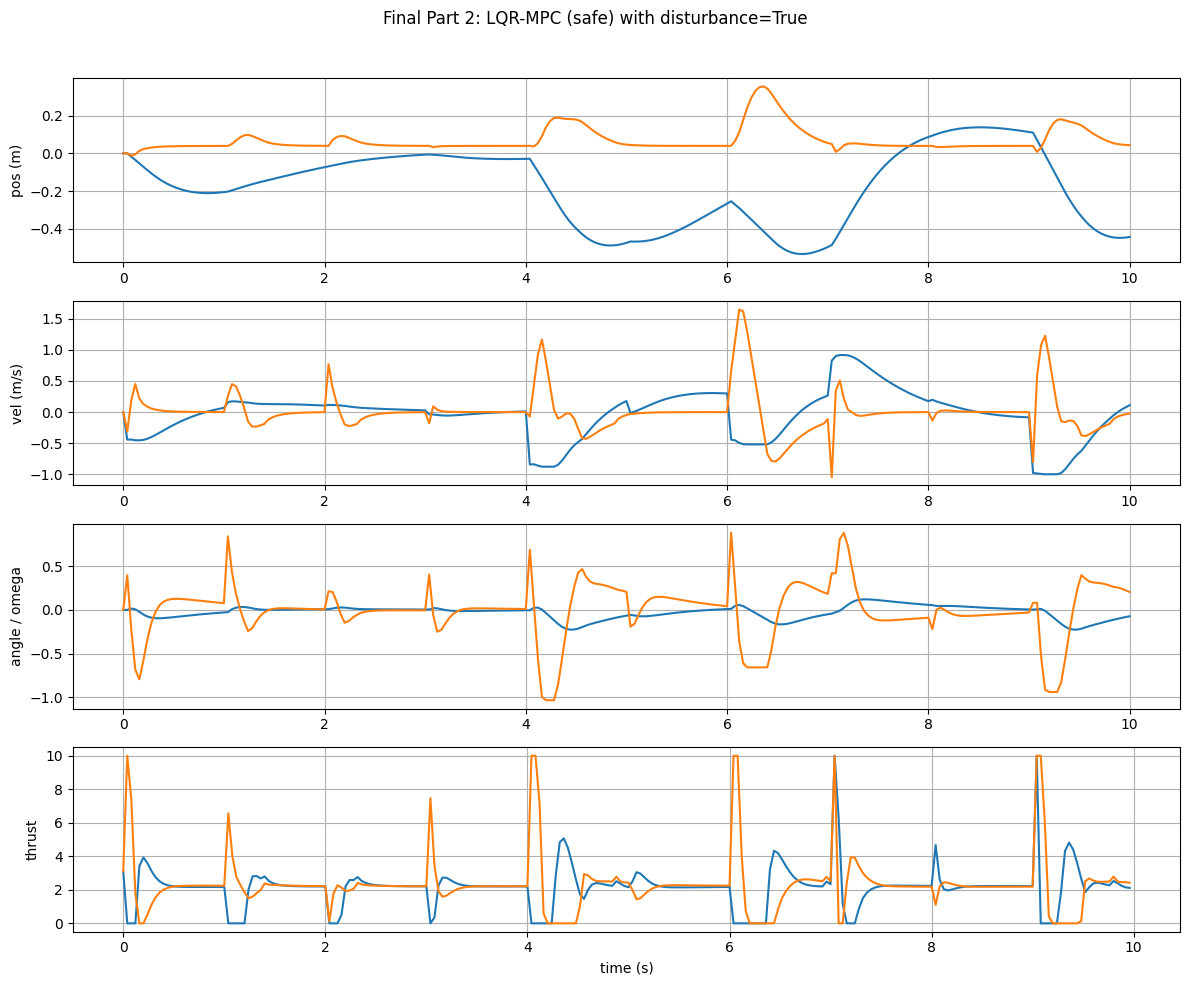

Basic verification -> min_u: 0.0 max_u: 10.0 min_py: -0.012378328187478178


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAjMVtZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAR
lWWIhAA7//73Tr8Cm0WXagOSVwr2yqQmWblSawHypgAAAwAAAwAAAwAAEflwsC7KIS5kkAAAAwAT
MALeAaoBVgGFPzkDRP3R4AERI/cBNkGx9FZhgpDIf0VhomFmALSJYUWHreQyZfuz7RzJ0Ha6IuCb
o11Svbkf7mr9Q6uQqy6dvN9P0k2ZxUioa7YqApDwfTslU58J0+DJUY0o+Wv4z4njWLIv4/uIspot
fnsI4vj+1ld72j6Q/eeEHONo+nZh7p8upEM0pOgjT6zjCEIhgRTXr39KN3jGsREEG3WP9iIqhMpc
g4MvufkUcYY+XWlDu3M8aYfc5m86RVe/RWPZyvyZccWXyYyvr1ZTIZ9kdb9/QvvmvQNJarDWHY68
ko6lD0/wV5wwIJg13zuuI6YsiJycewEx2qvKYiF3zOpPIFJD+kedXczbb/3/v3WnXPPDvwoDYElq
qHwKKzPiwJpLbvd2jesTpj8mFYxRCyYRpFT8iPR7Cnjc4w/PtHZI9ub7ryrrIiSvziYtq9xvi0R3
TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/Vn3Qaffk
8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1wVnmIEin6d0/2n7ff5Qk
udR2W5WhNcyFXOyrd97UA32BXDqBcJctX9U46kttH/DFJYH0hyX6vQT2C/q5r93/30LoXeFCUvZ2
UCm1QQEwWd7g6R8abZGdDHEQd4Wa/+X5Jyc/TuQ2tfAcRZiMNzOx5j9zi9JNFH3knoG9cPfXyAWv
VWp1qE8A+Wwxh87IhL7bp3FYF1ThTBCvrksq2XuJhGtzmL96zLuYDvavcqtPa8cv2zlZ81B2dwgW
FFsYA00vndeufUO8SRHevmrcbZkAt1RfU5cRk/CHqwVcAKY/lsMVfPT+5F1PwJKag+rrKjXBfnFk
1TKaJwWzHmrfEqqDG9JXoBbqqfnmac25oxnv/OtiLwQ/KaF9rZcYTJJhkheptrfRDtK0BfHGRYzT
y5/fqYLXy4QOAjxbSWN9byXsu0sSGoP8vtad+J7KysPfG/tSvVf6prNIdY0/d+3KsWap0/UQhsB4
3xZkLaaorPQMf54mtRAynBGjnLWBgsnFETVR6q/z8M/8wriqU0pKYJfaNPaONKZVm3EDfuB1SEnr
3QA8QrsI4oE86jrACzbEW1/Y68W2C4v9hVwnSOXIubF88IaZDvVUPrwYZ7DGlo+YiHGHedZQOhym
g34NrBncOawS9TYfCNoBvipBP6AXfj98hIizbRK1+y/WEVd2omVqnZNjHKkQAAhVKxG81DLCldi3
5J3QVWCmq83zVhfXmIoKKmn8veV0ncWvaoB2zqWoCLHxSjCRDlvqmv6ABCi0nSWUygh83m4IXwWk
AuNXUcWxTcJgxPtdHuZf/zGroGVUDEUfnaEFLAq+JVwjn4YNZ9Sclzx/y5rtYDHK66zBfLxFwnl2
UqvkwGHunkJJfPfb9EhExwOMUOfUmePX4JdHC3I4rRZz8sk/YaLI0pLg0zt1cwcUG5huaVO0LnRC
iCo0rVTErmvrODxBIJ3GreJ5I0x0tS5zSCwVRZEfjwFov1Y5wfolU1TeQNaIKtAJ/tpiJNikOd2n
f1GAza3znnj1/Gf3Qk7yP2/Ns6luN5+UUvgOKj9uCrR9RIWXgKf3n5LHF62iGvnGmS3TFNo8k7eV
iHAXYiqdcFrv7AXsMM3215/9AnLvACxHNa26fw1F+woNCQDRYl0oNr1jWIIYHKgy3EJf9jH4Bn8d
21qSRyryZX8ShC3Ux0DIWL7oVhshTdSKGEx6qqgRpf+4Rd2/I/la2a6i51Gk6lANCrZp2MlYV/vJ
SEs5O8npx10ZMoL/R5Dsji0gEgAAAwAAAwAAAwAAAwF2XYhfsohROuvg8j1wAeprQ1jz6icJ+V5K
kMk3VNzZHtjKN20d59EdB/FyfG2b9BZXZ8Xuk9tc4I3AA28Ln4NDnYMIG+96WyKccFFphx/AmZjo
6bLrI3n9Z/fCQylUZBNjamcdyD1AqTC7mkw4cQ/+L7g6bEQJdZ0PAZtXdoKr8cjngQV/5oXf7XJL
3aDKlrWv1wu364VPOgex7fAE2gxV9qVk0DPO9U0zzhli0rzGFEZ+OXgaSi2T6flbPh2doZyZEHJG
ZwtPwNVjl/etc4O742r8wYg8t/E7aahB9o11TREZ48Mjj0fXP/Jum3pqC/WKAH4zz0WAONnRBgnH
xn+dS4oVj20DImN3aZDR1/Zn9zqgzGM0Fftl84ITqQfIKsm2q4wcQgcHnhk21clnvKO/ZYOoThzl
Xb5t9dC0myA/WUlKOF10H+fuWY1x6504okVdd/+fyI/lJoF+1LuMKJDn1XxLajg/TB9/Z3u6g99i
Wh0eSmXBXIDWBwPMxGSXbSNjG0fO4w+TyApZ1XDeDGD8qORx/TcRPxQjRgukenjr+Z6DvC/gHQP1
OUStnTzPbUxyOCNs7/p2Q2f6nAz48p78ICZl8ttRebgX83BAY9eMFuVt0VEeYRRZe7nQvnb8/bX6
YC9PEv6umyudTN2ZjLHjf6xeHzJwcvMpk2aqbJS/HTLbIDGPp7kADVQi2+Gvuc3w/Vmv3zgUxp9+
wAa6xZGt2uhcpWSo3JgBC61IjGAvosSNs5mdPVO6k+Ci/WRGcXFePQyGMK9buJUNLIgw36FQgBBG
1lO/mV+f+HYL0k0f4AAAAwAAHRUfTjwUFuIUoLOyEz72hao8V2QKmzZIBjLLF0dAGBLc2cWZ8Ewe
8MtO6PkXynsucbnhtYocs6s7QYDFxEUNHFqAW8iEDM+eqV4idfDUQnL9lO0EhDHb8wLs/kQaK8IW
6PPG6K77mExuyRXx+Vqeq

Saved plots and CSVs to: .
Verification result (summary): None


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

DT = quadrotor.DT
n_x = quadrotor.DIM_STATE
n_u = quadrotor.DIM_CONTROL

m = quadrotor.MASS
g = getattr(quadrotor, "GRAVITY_CONSTANT", getattr(quadrotor, "GRAVITY", 9.81))
u_hover = 0.5 * m * g
u_hover_vec = np.array([u_hover, u_hover])

N_mpc = 25
Q = np.zeros((n_x, n_x))
Q[0,0] = 10.0
Q[2,2] = 10.0
Q[4,4] = 200.0
Q[1,1] = 1.0
Q[3,3] = 1.0
Q[5,5] = 1.0
R = 0.01 * np.eye(n_u)

try:
    f_c, A_cont, B_cont = cont_dynamics_and_jacobians(np.zeros(n_x), u_hover_vec)
except Exception:
    def cont_dynamics_and_jacobians_local(x, u):
        px, vx, py, vy, th, om = x
        u1, u2 = u
        I = quadrotor.INERTIA
        r = quadrotor.LENGTH
        m_local = quadrotor.MASS
        g_local = getattr(quadrotor, "GRAVITY_CONSTANT", getattr(quadrotor, "GRAVITY", 9.81))

        dpx = vx
        dvx = -(u1 + u2) * np.sin(th) / m_local
        dpy = vy
        dvy = (u1 + u2) * np.cos(th) / m_local - g_local
        dth = om
        dom = r * (u1 - u2) / I

        f_cont = np.array([dpx, dvx, dpy, dvy, dth, dom])

        A = np.zeros((n_x, n_x))
        B = np.zeros((n_x, n_u))

        A[0,1] = 1.0
        A[2,3] = 1.0
        A[4,5] = 1.0
        A[1,4] = -(u1+u2) * np.cos(th) / m_local
        A[3,4] = -(u1+u2) * np.sin(th) / m_local

        B[1,0] = -np.sin(th) / m_local
        B[1,1] = -np.sin(th) / m_local
        B[3,0] = np.cos(th) / m_local
        B[3,1] = np.cos(th) / m_local
        B[5,0] = r / I
        B[5,1] = -r / I

        return f_cont, A, B

    f_c, A_cont, B_cont = cont_dynamics_and_jacobians_local(np.zeros(n_x), u_hover_vec)

A_d = np.eye(n_x) + DT * A_cont
B_d = DT * B_cont

def dlqr_infinite(A, B, Q, R, max_iters=500, tol=1e-9):
    P = Q.copy()
    for _ in range(max_iters):
        BT_P = B.T @ P
        inv_term = np.linalg.inv(R + BT_P @ B)
        Pn = Q + A.T @ P @ A - A.T @ P @ B @ inv_term @ BT_P @ A
        if np.max(np.abs(Pn - P)) < tol:
            P = Pn
            break
        P = Pn
    K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)
    return K, P

K_lqr, P_final = dlqr_infinite(A_d, B_d, Q, R)

LOW_ALT = 0.08
DESCEND_VEL = -0.05

def mpc_lqr_controller_safe(x_state, t_idx):
    """
    Robust LQR + emergency ground override.
    - Uses LQR nominal command normally.
    - If predicted next py or current py is below margins, apply emergency thrust.
    - If severe descent, apply max thrust.
    """
    x = np.asarray(x_state).copy()
    px, vx, py, vy, th, om = x

    if py < 0.0:
        py = 0.0
        vy = max(vy, 0.0)
        x[2] = py
        x[3] = vy

    dx = x - np.zeros(n_x)
    du = -K_lqr @ dx
    u = u_hover_vec + du

    try:
        x_next = A_d @ x + B_d @ u
        py_next = float(x_next[2])
    except Exception:
        py_next = py + DT * vy

    SAFETY_MARGIN = 0.06
    SEVERE_DESCEND_V = -0.5
    SEVERE_PENETRATION = -0.05

    if py_next < SAFETY_MARGIN or py < SAFETY_MARGIN:
        depth = max(0.0, SAFETY_MARGIN - py_next)
        k_p = 2.0
        safety_acc = 1.0
        extra_force = m * (k_p * depth / max(DT,1e-6) + safety_acc)
        extra_per_rotor = extra_force / 2.0
        if vy < SEVERE_DESCEND_V or py < SEVERE_PENETRATION:
            u = np.array([10.0, 10.0])
        else:
            u = u + np.array([extra_per_rotor, extra_per_rotor])

    if py < -0.03:
        u = np.array([10.0, 10.0])

    u = np.clip(u, 0.0, 10.0)
    return u

def run_final_mpc(sim_time=10.0, disturbance=True, animate=True, save_dir="/mnt/data"):
    horizon_sim = int(sim_time / DT)
    print("Running simulation for", sim_time, "s -> steps:", horizon_sim)
    t, states, us = quadrotor.simulate(np.zeros(n_x), mpc_lqr_controller_safe, horizon_sim, disturbance=disturbance)

    st = np.asarray(states)
    ctrl = np.asarray(us)
    if st.ndim == 2 and st.shape[0] == n_x and st.shape[1] == horizon_sim + 1:
        st = st.T
    if ctrl.ndim == 2 and ctrl.shape[0] == n_u and ctrl.shape[1] == horizon_sim:
        ctrl = ctrl.T
    if ctrl.ndim == 1:
        ctrl = ctrl.reshape(-1, n_u)

    time = np.arange(st.shape[0]) * DT
    tu = np.arange(ctrl.shape[0]) * DT

    plt.figure(figsize=(12,10))
    plt.subplot(4,1,1)
    plt.plot(time, st[:,0])
    plt.plot(time, st[:,2])
    plt.grid()
    plt.ylabel('pos (m)')

    plt.subplot(4,1,2)
    plt.plot(time, st[:,1])
    plt.plot(time, st[:,3])
    plt.grid()
    plt.ylabel('vel (m/s)')

    plt.subplot(4,1,3)
    plt.plot(time, st[:,4])
    plt.plot(time, st[:,5])
    plt.grid()
    plt.ylabel('angle / omega')

    plt.subplot(4,1,4)
    plt.plot(tu, ctrl[:,0])
    plt.plot(tu, ctrl[:,1])
    plt.grid()
    plt.ylabel('thrust')
    plt.xlabel('time (s)')
    plt.suptitle('Final Part 2: LQR-MPC (safe) with disturbance={}'.format(disturbance))
    plt.tight_layout(rect=[0,0,1,0.96])

    if not os.path.exists(save_dir):
        save_dir = '.'

    plt.savefig(os.path.join(save_dir, 'part2_final_plots.png'), dpi=150)
    plt.show()

    np.savetxt(os.path.join(save_dir, 'part2_states.csv'), st, delimiter=',', header='px,vx,py,vy,theta,omega', comments='')
    np.savetxt(os.path.join(save_dir, 'part2_controls.csv'), ctrl, delimiter=',', header='u1,u2', comments='')

    verify_results = None
    try:
        verify_results = verify_mpc_disturbance_aware(t, st, ctrl, name="Final LQR-MPC")
    except Exception:
        try:
            verify_results = verify_mpc_output(t, st, ctrl, name="Final LQR-MPC")
        except Exception:
            min_u = float(np.min(ctrl))
            max_u = float(np.max(ctrl))
            min_py = float(np.min(st[:,2]))
            print("Basic verification -> min_u:", min_u, "max_u:", max_u, "min_py:", min_py)

    try:
        quadrotor.animate_robot(st.T, ctrl.T, DT)
    except Exception as e:
        print("Animation failed:", e)
        try:
            quadrotor.animate_robot(states, us, DT)
        except Exception as ee:
            print("Animation secondary attempt failed:", ee)

    print("Saved plots and CSVs to:", save_dir)
    return t, st, ctrl, verify_results

t_final, st_final, u_final, verify_final = run_final_mpc(sim_time=10.0, disturbance=True, animate=True, save_dir="/mnt/data")
print("Verification result (summary):", verify_final)


## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

def controller(x, t):
    return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMRNtZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAR
HGWIhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAAAwAANJjQfjN3asOGIAAAAwAm
AAYIA2ADMAR3AEmGJ+s/AAvBEWQEnA/MlSYUZPaodejibpEKK0iWFFh63emKh7s+0cyc7gmSe0m6
NdUr2am+mi/UOrkKsunbr4T+qLLZcnUNdsVAUh4Pp2Ph39hyDgyVGNKPkX+M7h2d5lspyEGTERHX
53Boux6hBNQ4gd74CMx3/TWPeWQe6fK6YcYBMXlB+4Yw0SGYCKJQBg4h4fEWIiCDbLH+xESwmUOQ
eCCfPyJuMMfLqyh3Xl6NMPuczedIqffnrHs1T6suOLL5MZXvOUpkE+K8whq8T75r0DSWqwlh2CvJ
KMowdP8FecMCCYNd87riOmLIY8UCq2QVYnlMRCV5nUnkCkiIBuuamJ8N6fPv4v8CbPDvvKXZPDx1
X+/N082AfI0w93tB66unUq8430qmKKr1YtxeAC7qs7hUkXesAS3yzr2SPbXt1O+1kRJX5xMW1ebc
xaI7p3o1o16zYnHIiBryP8xbcKoEheOGQta91Jwpm+DwxVqqu9he48e1d2jH7aO0yXqsT2b/qz7o
LLlMh42NpdefVJNDJY1OfyvQoZjldRTxhaPitkhpSQGq91Pwe5RR/6jlcnbr7csqIESuhyfqPj2q
ryhJc6UQk6tUHJD8AkGu+EhaansCuHUC4S5axJlvzarBRfhiksD6OEyqPybv3f/fQuld4UJS9nZQ
J7VbqnZgE+O7dcJFu/VJRaH48LNf/L8k5Ofl1ooAaqmV+OHmysR5j9zi9JNFH3knwzmfj9MZwDEt
Dc+ssdzYYw+dkQl/GgL7AFiEEDKmL8XL3EwjW5y8fKYi7l3jba3Kd+q4dTKs+z4SgYlYApKHuwD/
UxU0dARmfw9XHQTvN0ALNJKk44ZNaFoXnuVNmbC/bkACbVFalBlA0CMMHCyxsbOftP0BRi8HlNE4
LZjzVviVVGjzkr0At1VPzzNObc1Am2CEqRF1FKmqFS0iuMJkozKQ6Wba30Q7StAXlm4J8f+XP79T
Ba+YM9Of1xMrnPdXGXsu0sRuGHlV/HvWJ7KysPwv/0hCZ/6rbMUmHtKH7xilG6p0/UQhsB44S4Yj
JcBnx0TETeCBLcLTjImMCC0cU9/CgKTh7lXIPX5hXFUppD7J4wXocYrszsF0bT75WJBJR5xmRzKr
W0LJF4nbNAFm2Iv5DeWjG1Z17BJpD42dU3t8byrOJV9DnkWy3zoQdFt+np6dfqXrT1JUupzyFzF/
98JDBQDfFSCf0AvNf8oioizbTiyVZg3gGTeLQ8x2/iYA9DeRg+EtnYYkWuqYyw6Yopz58aQheIKx
kigoXlF6WLqoi+S0H+yMAAADAAADAkWyMDgiQ3CAAD25LJ0pCgACE8MQmths/crKZEaBrVS6iGbE
qFkfZifmUrRbNJwvZYaNMH96RN3LRCPq/RXGzGX0hFIuE8ZirDiWjSH0bLUvnvt+isUUpHGKHPqT
PHr8EujiKLJi/aGN1s3xaKDnG1ivXAY3HQqHwUYmmVm1jes1fWyLPsZsTEraKWBmhjci9KrIb6un
c0hgHKB1AFj2CiLpAv0SqQhoZKtO2qErGRMMEsS01lHZ52taZrsTeD7I/3zZQwjb1ysY3WGqskiw
B1lyam0FT9vNr+rWK3dDijr01mm/B0EsNOalG+h85u/ArhkGkFLZkyKVJF8XW70AZzNMtZwMfQtf
iWQbwhfN6dXmoQEfTeK+kUIP3ANaNnTm691XTUNtejDN7LQC1g+Rh9f5BYABlbMRmDCvTVfkKTmc
nnUi8DVTPqSWMS7keoR/li35HvkBQldxmsdZOGEC7d0YLs2yAeuk7peDRH0D/oW6nCP2MHVPeACg
eFzECG5TWqC/O6XOiAtYWf4AAAMAAGTAZo2izrBw3f0RDf/MbCjEBBP1mHsk9IcOJjhJ5AoT6/54
YEWIsEPO30eqqT6RJN9/ujxQTekHFQp7XVIwd5x3x4DNCZYGBfjkc8CCv/NDJ9sJ4jLHu61bBNmX
NAVFFI6B7Ht7/nVrMN+ZWnVJStghscUU+UclNBzyDclp6vT49F9jaMl80SMNcX3sVLnleA3kOy4p
SsWyVvxeylzfenxiiSy/g0erWOgwYEEr2zJ2++aKb0VZTvE0usY8x5ro1koTNq+f6j+9sGroii+p
bvliCVUmuBceM/cEm/UBnn/0J8qaWtcYCqTd02ZRE1H6zlwsuSyBnjSIT9BE9EVkEVbEwMJT8AoJ
6I3eyEulhjVv8CMSnUPA2XXSbuHn0OjM9Q8YUoiBi79qmKqA4HHdP6+LMZQ1oTpOuVoZl4YJZj+j
KWcr/wnj+wAanuDytzjkKDLJTeQUiTA4S5QYZc1s5YAvC2h0Dja/5TzB+alAvK3eGTgTKSl3PUSc
PZlbtdB1LVfOhp66QJzmFwIUeYChfeV6ktIq3OP9hn99o/mx/9orJRRNfmBKbusXHVr8aC1jdbIM
h/l7UX8NgmIDAwQWhSh/YmMwl28FVsTwoBClcD4+vkubaHcOtRSql6wTdPeCbs/73+ozSXLDzbHg
FhsmACoAAAMAAAePZbSwl5APjYHmkW8wkovTV40uMjXppUocsbAedhL4dy8VE+NOV19XHvd/AJSt
QFtfb0lrX00m0thnwyFb7wkHGDiG6vjl3+erb9uKOfEjQm/eW7h/iCl9ww1Ve4apyd3PXJ8hCwy/
ZqLGg0M3oSIgD1jED8PN4ZnM/Eb4MR5pwJzOQGcwIwLZZjYo+hPBzaC9+yB3xxfgyS5nkeJ8CE/u
z6Daxcnl+6czA+IELD8gQTVzePCHAcR5dmnVAOflZYpLwp488s9kTLIOE0ZIUdM3Zy1pu/6maOV4
Cvsqlgkce7uflphfC1QuK